<a href="https://colab.research.google.com/github/Karthikt04/NM/blob/main/fakeNewsPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install --quiet scikit-learn pandas joblib

import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

In [19]:
# Upload datasets (use Colab file picker)
from google.colab import files

print("Upload training data set:")
uploaded = files.upload()
print("Upload test.csv:")
uploaded = files.upload()

# Ensure files are in the working directory
df_train = pd.read_csv('xy_train.csv')
df_test = pd.read_csv('x_test.csv')

Upload training data set:


Saving xy_train.csv to xy_train (2).csv
Upload test.csv:


Saving x_test.csv to x_test (2).csv


In [31]:
# Data cleaning - drop label '2'
df_train = df_train[df_train['label'].isin([0, 1])]
print(f"Training samples after drop: {df_train.shape[0]}")
df_train['label'].value_counts()

Training samples after drop: 47813


,count
label,
0,25798
1,22015


In [21]:
# Define feature pipeline
def build_pipeline():
    union = FeatureUnion([
        ('tfidf_word', TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=10000)),
        ('tfidf_char', TfidfVectorizer(analyzer='char', ngram_range=(2,5), max_features=5000)),
        ('count_word', CountVectorizer(analyzer='word', ngram_range=(1,2), max_features=10000)),
    ], n_jobs=-1)
    pipe = Pipeline([
        ('features', union),
        ('clf', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    ])
    return pipe

pipeline = build_pipeline()

In [22]:
# Evaluate with cross-validation
X = df_train['text']
y = df_train['label']
scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print("5-fold ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())

5-fold ROC-AUC scores: [0.91186713 0.91483964 0.91384746 0.90665583 0.90874834]
Mean ROC-AUC: 0.9111916797792821


In [23]:
# Train final model on all data
pipeline.fit(X, y)


Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('tfidf_word',
                                                 TfidfVectorizer(max_features=10000,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('tfidf_char',
                                                 TfidfVectorizer(analyzer='char',
                                                                 max_features=5000,
                                                                 ngram_range=(2,
                                                                              5))),
                                                ('count_word',
                                                 CountVectorizer(max_features=10000,
                                                                 ngram_range=(1,
                                                                              2)))])),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [24]:
# Save the trained model
joblib.dump(pipeline, 'fake_news_model.pkl')
print("Model saved as 'fake_news_model.pkl'")

Model saved as 'fake_news_model.pkl'


In [25]:
# Generate predictions on test set
df_test['label'] = pipeline.predict(df_test['text'])
df_test[['ID','label']].to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


In [26]:
# Optional: Download predictions file
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Load and clean dataset (dropping label 2)
df_train = pd.read_csv('xy_train.csv')
df_train = df_train[df_train['label'].isin([0, 1])]
df_train.reset_index(drop=True, inplace=True)


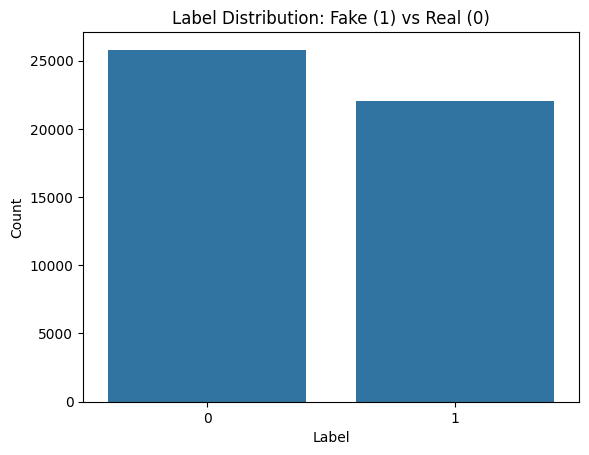

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df_train)
plt.title('Label Distribution: Fake (1) vs Real (0)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


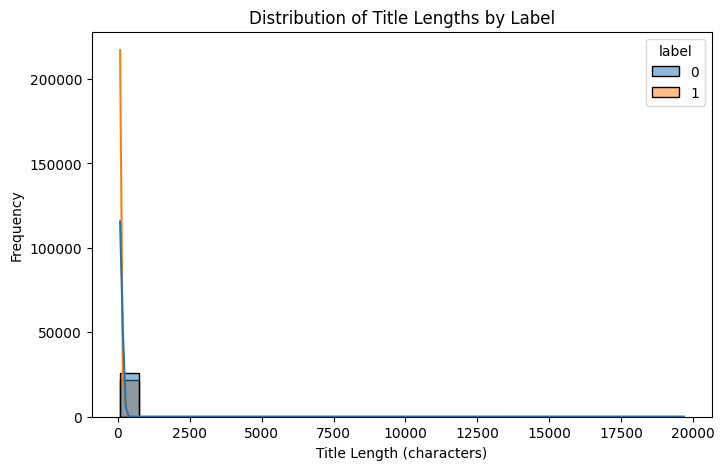

In [29]:
df_train['title_length'] = df_train['text'].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='title_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Title Lengths by Label')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.show()


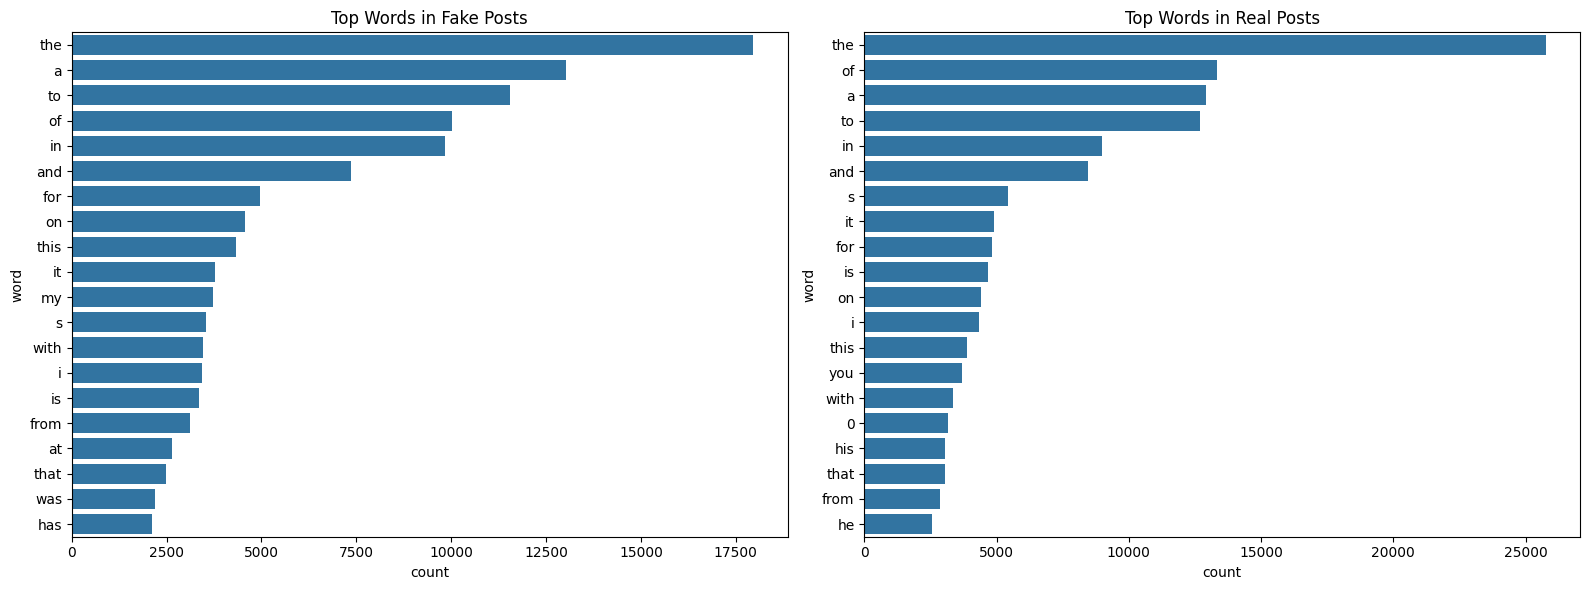

In [30]:
from collections import Counter
import re

def get_top_words(data, label, n=20):
    texts = data[data['label'] == label]['text'].str.lower()
    words = re.findall(r'\b\w+\b', ' '.join(texts))
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=['word', 'count'])

top_fake = get_top_words(df_train, label=1)
top_real = get_top_words(df_train, label=0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x='count', y='word', data=top_fake, ax=axes[0]).set(title='Top Words in Fake Posts')
sns.barplot(x='count', y='word', data=top_real, ax=axes[1]).set(title='Top Words in Real Posts')
plt.tight_layout()
plt.show()
